In [1]:
import os
import seaborn as sns
import numpy as np
import torch

from scvi.dataset import CellMeasurement, AnnDatasetFromAnnData, GeneExpressionDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

import anndata
import scanpy as sc

from scvi import set_seed

sns.set(context="notebook", font_scale=1.15, style="ticks")
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598", "#CFDD45"]
sns.set_palette(sns.color_palette(colors))

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

set_seed(0)

In [2]:
# Load anndata
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_206 = anndata.read(save_path + "spleen_lymph_206.h5ad")

# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]]
)
keep_pro_206 = np.array(
    [
        not (p.startswith("HTO") or p.startswith("ADT_Isotype"))
        for p in anndataset_206.uns["protein_names"]
    ]
)

anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]
anndataset_206.obsm["protein_expression"] = anndataset_206.obsm["protein_expression"][
    :, keep_pro_206
]
anndataset_206.uns["protein_names"] = anndataset_206.uns["protein_names"][keep_pro_206]

# Organize and instantiate scVI dataset
hvg_111 = anndataset_111.var["hvg_encode"]
hvg_206 = anndataset_206.var["hvg_encode"]

assert (hvg_111 == hvg_206).all()

dataset_111 = AnnDatasetFromAnnData(ad=anndataset_111[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111.initialize_cell_measurement(protein_data_111)
dataset_111.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_206 = AnnDatasetFromAnnData(ad=anndataset_206[:, hvg_111])
protein_data_206 = CellMeasurement(
    name="protein_expression",
    data=anndataset_206.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_206.uns["protein_names"],
)
dataset_206.initialize_cell_measurement(protein_data_206)
dataset_206.gene_names = anndataset_206[:, hvg_206].var_names.values


dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset_111, dataset_206],)

[2020-02-07 18:50:28,471] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-02-07 18:50:28,477] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-02-07 18:50:28,634] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-02-07 18:50:28,811] INFO - scvi.dataset.dataset | Downsampled from 16828 to 16828 cells
[2020-02-07 18:50:30,538] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-02-07 18:50:30,542] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-02-07 18:50:30,682] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-02-07 18:50:30,834] INFO - scvi.dataset.dataset | Downsampled from 15820 to 15820 cells
[2020-02-07 18:50:31,457] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-02-07 18:50:31,925] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-02-07 18:50:32,212] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-02-07 1

In [3]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
    n_batch=dataset.n_batches,
)

In [4]:
model.load_state_dict(torch.load("sln_all_intersect.pt"))
model.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4119, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [5]:
use_cuda = True
trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

In [6]:
full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)

In [7]:
post_adata = anndata.read("sln_all_intersect_post_adata.h5ad")

In [8]:
post_adata.obs["batch_indices"] = [str(b[0]) for b in dataset.batch_indices]

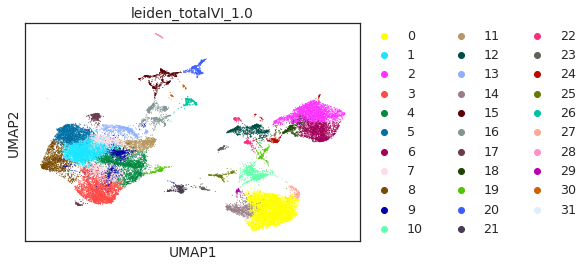

In [12]:
sc.pl.umap(
    post_adata, 
    color=["leiden_totalVI_1.0"],
    ncols=1
)